In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations
from scipy.stats import friedmanchisquare

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/harmonic'):
    os.makedirs('../paper/harmonic')

from _load_data import * # Getting our specific labels, formatting, and data

from _cd_diagram import draw_cd_diagram

# Getting some free samples
results_df.sample(3)

# Don't change any code below, it may break (probably will) --------------------



['../models/SimplifierTopDown.py', '../models/SimplifierBottomUp.py', '../models/Vanilla.py'] ['Simplifier Top Down', 'Simplifier Bottom Up', 'Without simplification']
(540, 14)
['Simplifier Top Down' 'Simplifier Bottom Up' 'Without simplification']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Tower']


,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth
508,Simplifier Bottom Up,Tower,0,29198,2802.848470,01-14-2024 10:27:09,0.522391,0.564175,0.310827,0.284821,"cdiv(x_5, maximum(add(x_8, x_0), square(square(mul4(x_3, x_9, x_14, x_0)))))",13,985,5
156,Without simplification,Concrete,0,6832,956.009094,01-13-2024 23:32:36,0.670389,0.647403,69.831492,75.257846,"sqrtabs(minimum(add3(x_0, cdiv(-620733.6221243847, x_0), add(4647.553518287642, x_5)), multiply(add4(-241.8685043450453, x_2, x_0, x_1), sqrtabs(multiply(x_7, square(cdiv(301.832875191155, x_3)))))))",23,1320,7
233,Simplifier Bottom Up,Energy Cooling,0,31658,1442.121596,01-14-2024 00:20:37,0.867650,0.893922,10.046313,8.581218,"mul3(x_0, mul3(cdiv(mul3(x_0, sqrtabs(x_2), add4(-105.6821372152048, x_4, x_1, x_5)), subtract(cos(x_6), x_6)), x_4, 1.5126947000975729e-06), x_1)",20,7896,5


criteria               Harmonic Mean size mean score                      \
                                mean              lb      mean        ub   
model                                                                      
Simplifier Top Down         2.009506        2.099902  2.161111  2.222321   
Simplifier Bottom Up        1.962044        2.109716  2.241667  2.373618   
Without simplification      1.910863        1.411779  1.597222  1.782666   

criteria               test_mse mean score                      
                                        lb      mean        ub  
model                                                           
Simplifier Top Down               1.825331  1.877778  1.930225  
Simplifier Bottom Up              1.626766  1.744444  1.862123  
Without simplification            2.311010  2.377778  2.444546

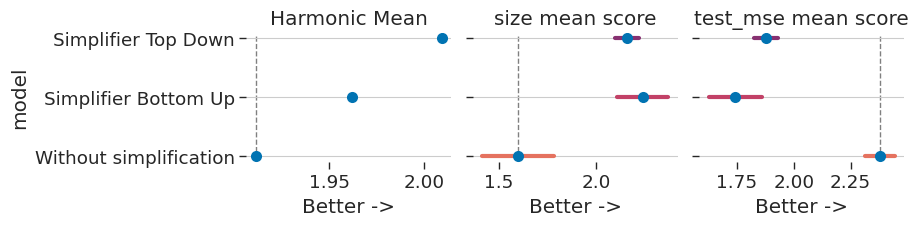

criteria               Harmonic Mean complexity mean score            \
                                mean                    lb      mean   
model                                                                  
Simplifier Top Down         2.081181              2.032016  2.177778   
Simplifier Bottom Up        2.049482              2.041506  2.105556   
Without simplification      1.796794              1.534399  1.716667   

criteria                         depth mean score                      \
                              ub               lb      mean        ub   
model                                                                   
Simplifier Top Down     2.323540         2.037093  2.138889  2.240685   
Simplifier Bottom Up    2.169605         2.122760  2.186111  2.249462   
Without simplification  1.898934         1.548274  1.675000  1.801726   

criteria               size mean score                      \
                                    lb      mean        ub   
model                                                        
Simplifier Top Down           2.099902  2.161111  2.222321   
Simplifier Bottom Up          2.109716  2.241667  2.373618   
Without simplification        1.411779  1.597222  1.782666   

criteria               test_mse mean score                      
                                        lb      mean        ub  
model                                                           
Simplifier Top Down               1.825331  1.877778  1.930225  
Simplifier Bottom Up              1.626766  1.744444  1.862123  
Without simplification            2.311010  2.377778  2.444546

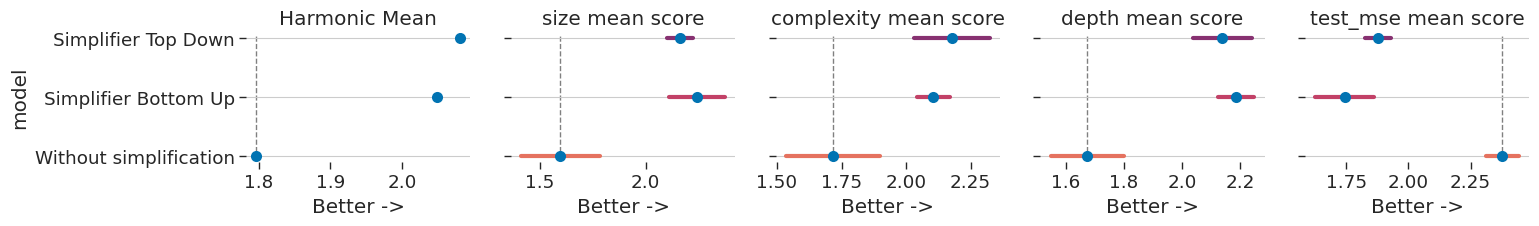

criteria               Harmonic Mean complexity mean score            \
                                mean                    lb      mean   
model                                                                  
Simplifier Top Down         2.081181              2.032016  2.177778   
Simplifier Bottom Up        2.049482              2.041506  2.105556   
Without simplification      1.796794              1.534399  1.716667   

criteria                         depth mean score                      \
                              ub               lb      mean        ub   
model                                                                   
Simplifier Top Down     2.323540         2.037093  2.138889  2.240685   
Simplifier Bottom Up    2.169605         2.122760  2.186111  2.249462   
Without simplification  1.898934         1.548274  1.675000  1.801726   

criteria               size mean score                      \
                                    lb      mean        ub   
model                                                        
Simplifier Top Down           2.099902  2.161111  2.222321   
Simplifier Bottom Up          2.109716  2.241667  2.373618   
Without simplification        1.411779  1.597222  1.782666   

criteria               test_mse mean score                      
                                        lb      mean        ub  
model                                                           
Simplifier Top Down               1.825331  1.877778  1.930225  
Simplifier Bottom Up              1.626766  1.744444  1.862123  
Without simplification            2.311010  2.377778  2.444546

In [2]:
def plot_rankings(columns, results_df, path):
    ranks_data = []
    for col in columns:
        ranks_df = results_df.pivot( # Smaller is better for all columns here
            index=['dataset', 'RunID', 'random_state'], columns='model', values=col
        ).rank(ascending=False, axis=1).groupby('dataset').mean()#.rank(ascending=False, axis=1)
        
        for model in results_df['model'].unique():
            df_model = ranks_df[ model ]
            values = df_model.values

            # Estimating lower and upper confidence bounds
            lb, ub = stats.norm.interval(confidence=0.95, loc=np.mean(values),
                                        scale=stats.sem(values))
            lb = np.nan_to_num(lb, 0.0)
            ub = np.nan_to_num(ub, 0.0)

            ranks_data.append( (model, f'{col} mean score', df_model.mean(), lb, ub) )

    # Creating the dataframe
    ranks_data_df = pd.DataFrame(data=ranks_data,
                                columns=['model', 'criteria', 'mean', 'lb', 'ub'])

    ranks_data_df = ranks_data_df.pivot(columns='criteria', index='model')

    # will calculate the harmonic mean and plot the columns based on mean rankings
    ranks_data_df[('mean', 'Harmonic Mean')] = (
        ranks_data_df[[('mean', f'{col} mean score') for col in columns]]
    )['mean'].apply(stats.hmean, axis=1)

    ranks_data_df = ranks_data_df.sort_values(by=('mean', 'Harmonic Mean'), ascending=False)
    ranks_data_df = ranks_data_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    display(ranks_data_df)
    #print(ranks_data_df.to_latex())

    # Use semantically meaningful titles for the columns
    titles = ['Harmonic Mean']+[f'{col} mean score' for col in columns]

    # Now making the plot
    g = sns.PairGrid(ranks_data_df.reorder_levels([1, 0], axis=1)['mean'].reset_index(),
                    x_vars=titles, y_vars=['model'], height=2.5, aspect=1.25)

    # Draw a dot plot using the stripplot function
    g.map(sns.stripplot, size=8, orient="h", jitter=False,
        palette="flare_r", linewidth=0, edgecolor="w")

    # setting the reference as the Baseline 
    unif = ((ranks_data_df[ ranks_data_df.index=='Without simplification'])['Harmonic Mean'])['mean'].values[0]
    g.axes.flat[0].axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

    g.axes.flat[0].set(title='Harmonic Mean')
    g.axes.flat[0].set_xlabel('Better ->')
    #g.axes.flat[0].set_xlim( (-1, len(ranks_data_df.index)+1) )

    # Make the grid horizontal instead of vertical
    g.axes.flat[0].xaxis.grid(False)
    g.axes.flat[0].yaxis.grid(True)

    for ax, title in zip(g.axes.flat[1:], titles[1:]):
        color = iter(sns.color_palette("flare_r", ranks_data_df.shape[0]))
        for tick, text in zip(g.axes.flat[0].get_yticks(), g.axes.flat[0].get_yticklabels()):
            c=next(color)
            sample_name = text.get_text()  # "X" or "Y"
            single_df = ranks_data_df[ ranks_data_df.index==sample_name ]
            
            lb, ub, mean_val = (single_df[title])[ ['lb', 'ub', 'mean'] ].values[0]
            rank_val = ranks_data_df.reset_index()[(ranks_data_df.reset_index()['model']==sample_name)].index

            # plot horizontal lines across the column, centered on the tCIk
            ax.plot([lb, ub], [rank_val, rank_val], lw=3, color=c)

        # Draw a reference line on baseline
        unif = (ranks_data_df[ ranks_data_df.index=='Without simplification'])[(title, 'mean')].values[0]
        ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)

        # Set a different title for each axes
        ax.set(title=title)
        ax.set_xlabel('Better ->')
        #ax.set_xlim( (-1, len(ranks_data_df.index)+1) )

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.savefig(f'{path}.pdf')
    plt.savefig(f'{path}.png', dpi=600)

    plt.show()

    return ranks_data_df

plot_rankings(['size', 'test_mse'], results_df, "../paper/figs/size_mse")
plot_rankings(['size', 'complexity', 'depth', 'test_mse'], results_df, "../paper/figs/size_mse_compexity_depth")
